In [1]:
import json
from datetime import datetime , timezone
import time
import numpy as np
import codecs
import struct
import matplotlib.pyplot as plt
import pandas as pd
import pickle
%matplotlib inline

### 1. Pick a session to work with!

In [2]:
metadata = pickle.load(open('./cleaned_data/metadata.p', 'rb'))
print('Please Choose a Session to Work With:')
for k in metadata: print(k, end=',  ')

Please Choose a Session to Work With:
david_2,  patrick_1,  patrick_2,  beata_1,  david_3a,  david_3b,  irmandy_1,  juliana_1,  

In [3]:
SESSION = 'juliana_1'

let's print some basic summary statistics based on the metadata for this session:

In [5]:
s_meta = metadata[SESSION]

try:
    print(SESSION, 'on', s_meta['date'])
    print('-'*10)
    print(s_meta['glasses_sessions_total_duration_string'], 'hr of glassess data starting at', \
          s_meta['glasses_session_times'][0][0])
    print('%02d:%02d hr of    video data starting at ' % (s_meta['vid_duration_sec'] / 60 // 60, 
           s_meta['vid_duration_sec'] / 60 % 60 )  + s_meta['vid_start'])
    print('-'*10)
    print('glasses sessions:')
    for i in range(len(s_meta['glasses_session_times'])):
        print('session ' + str(i) + ':',s_meta['glasses_session_times'][i][0],'to',\
              s_meta['glasses_session_times'][i][1],'\tduration:%8.2f min' % s_meta['glasses_session_durations_min'][i])
except:
    print('failed to load video analysis file.')

juliana_1 on 04/09
----------
04:03 hr of glassess data starting at 04/09/21 10:22:05AM EDT
05:58 hr of    video data starting at 04/09/21 10:21:33AM EDT
----------
glasses sessions:
session 0: 04/09/21 10:22:05AM EDT to 04/09/21 10:43:30AM EDT 	duration:   21.42 min
session 1: 04/09/21 10:44:42AM EDT to 04/09/21 12:07:24PM EDT 	duration:   82.71 min
session 2: 04/09/21 01:12:42PM EDT to 04/09/21 01:58:52PM EDT 	duration:   46.16 min
session 3: 04/09/21 02:08:09PM EDT to 04/09/21 02:34:53PM EDT 	duration:   26.73 min
session 4: 04/09/21 02:47:09PM EDT to 04/09/21 03:53:47PM EDT 	duration:   66.63 min


### Load the Data
...and let's load in the data, and plot what we have just to take a look, by session

In [6]:
#load video data (eyeratio and openface features), 60 Hz (16 ms between samples)
df_vid = pd.read_csv('./cleaned_data/' + SESSION + '/video_consolidated.csv', index_col=0)

#load glasses blink data, 1kHz (1 ms between samples)
blink_sess = pickle.load(open('./cleaned_data/' + SESSION + '/sessions_blink.p', 'rb'))

#load glasses accel data, 10 Hz (100 ms between samples)
accel_sess = pickle.load(open('./cleaned_data/' + SESSION + '/sessions_accel.p', 'rb'))

#s_meta['start_error_sec'] will be useful for when we xcorr

# give some stupid FutureWarning error thanks to pandas and numpy not being in sync.
# https://stackoverflow.com/questions/48818335/why-pandas-read-csv-issues-this-warning-elementwise-comparison-failed

/usr/local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [13]:
df_vid.head()

,eye_ratio,tick_ms,est_timestamp_ms,AU45_r,AU45_c,pose_Rx,pose_Ry,pose_Rz,pose_Tx,pose_Ty,pose_Tz
0,NaN,0,1617978093000,0.0,0.0,-0.456,0.494,-0.023,-20929110.0,-11772625.0,28614018.0
1,NaN,17,1617978093017,0.0,0.0,-0.456,0.494,-0.023,-20929110.0,-11772625.0,28614018.0
2,NaN,33,1617978093033,0.0,0.0,-0.456,0.494,-0.023,-20929110.0,-11772625.0,28614018.0
3,NaN,50,1617978093050,0.0,0.0,-0.456,0.494,-0.023,-20929110.0,-11772625.0,28614018.0
4,NaN,67,1617978093067,0.0,0.0,-0.456,0.494,-0.023,-20929110.0,-11772625.0,28614018.0


In [17]:
blink_sess[0].head()

,timestamp_ms,value
0,1617978125354,100
1,1617978125355,100
2,1617978125356,100
3,1617978125357,100
4,1617978125358,100


In [18]:
accel_sess[0].head()

,timestamp_ms,quatI,quatJ,quatK,quatReal,quatRadianAccuracy
0,1617978125453,-0.332336,-0.662903,-0.360962,0.565491,1.623047
1,1617978125553,-0.332458,-0.663696,-0.362610,0.563416,1.623047
2,1617978125653,-0.324829,-0.668335,-0.393677,0.541138,1.623291
3,1617978125753,-0.317322,-0.669617,-0.403687,0.536621,1.623535
4,1617978125953,-0.332092,-0.655701,-0.380066,0.561584,1.624023


#### Let's plot it to make sure it looks normal

In [22]:
#time_col is 'timestamp_ms' in glasses, 'est_timestamp_ms' for estimate in video until x-corr-ed and time aligned
def df_between_timestamps(df, time_col, start_time, end_time):
    return df[(start_time <= df[time_col]) & (df[time_col] <= end_time)]

def plot_session(df_sess, df_vid, plot_type='blink', vid_timestamp='est_timestamp_ms'):
    df_vid = df_between_timestamps(df_vid, vid_timestamp, 
                                   df_sess['timestamp_ms'].iloc[0], 
                                   df_sess['timestamp_ms'].iloc[-1])
    if plot_type == 'blink':
        fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(12,4))
        
        ax[0].plot(df_sess['timestamp_ms'], df_sess['value'])
        ax[0].set(xlabel='timestamp (ms)', ylabel='raw value', title='Glass Blink Data')
        ax[0].grid()

        ax[1].plot(df_vid[vid_timestamp], df_vid['eye_ratio'])
        ax[1].set(xlabel='timestamp (ms)', ylabel='ratio', title='Eye Ratio')
        ax[1].grid()
        
        ax[2].plot(df_vid[vid_timestamp], df_vid['AU45_c']*5, label='AU45_c')
        ax[2].plot(df_vid[vid_timestamp], df_vid['AU45_r'], label='AU45_r')
        ax[2].set(xlabel='timestamp (ms)', ylabel='blink feature', title='Openface Code')
        ax[2].grid()
        fig.tight_layout()
        plt.show()
    
    if plot_type == 'accel':
        fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(12,4))
        
        ax[0].plot(df_sess['timestamp_ms'], df_sess['quatI'], label='I')
        ax[0].plot(df_sess['timestamp_ms'], df_sess['quatJ'], label='J')
        ax[0].plot(df_sess['timestamp_ms'], df_sess['quatK'], label='K')
        ax[0].set(xlabel='timestamp (ms)', ylabel='raw value', title='Glass Quat Data')
        ax[0].grid()

        ax[1].plot(df_vid[vid_timestamp], df_vid['pose_Rx'], label='X')
        ax[1].plot(df_vid[vid_timestamp], df_vid['pose_Ry'], label='Y')
        ax[1].plot(df_vid[vid_timestamp], df_vid['pose_Rz'], label='Z')
        ax[1].set(xlabel='timestamp (ms)', ylabel='rad', title='Video Rotation Data')
        ax[1].grid()
        
        ax[2].plot(df_vid[vid_timestamp], df_vid['pose_Tx'], label='X')
        ax[2].plot(df_vid[vid_timestamp], df_vid['pose_Ty'], label='Y')
        ax[2].plot(df_vid[vid_timestamp], df_vid['pose_Tz'], label='Z')
        ax[2].set(xlabel='timestamp (ms)', ylabel='mm', title='Video Translation Data')
        ax[2].grid()
        fig.tight_layout()
        plt.show()


BLINK SESSION 0


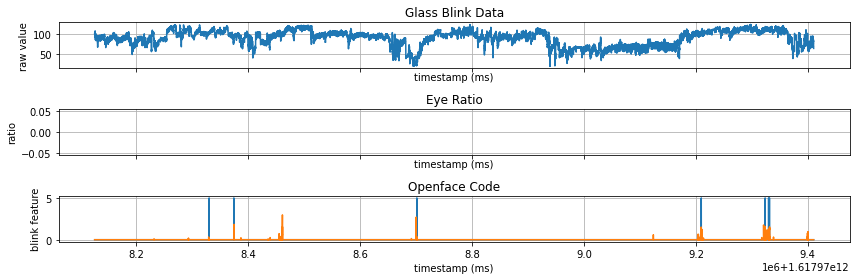

BLINK SESSION 1


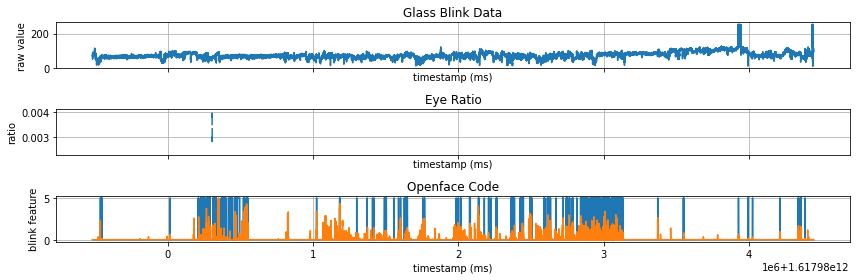

BLINK SESSION 2


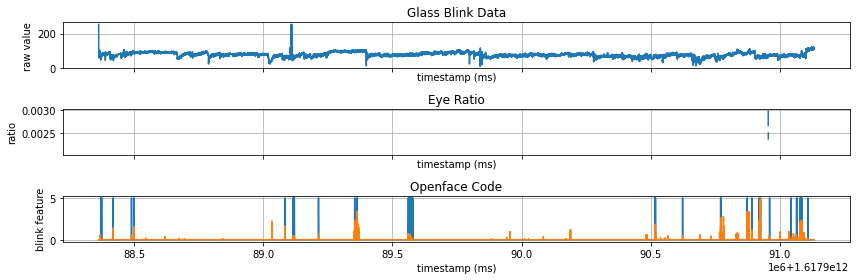

BLINK SESSION 3


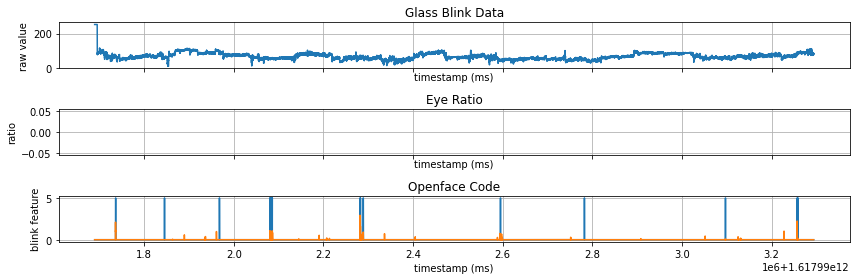

BLINK SESSION 4


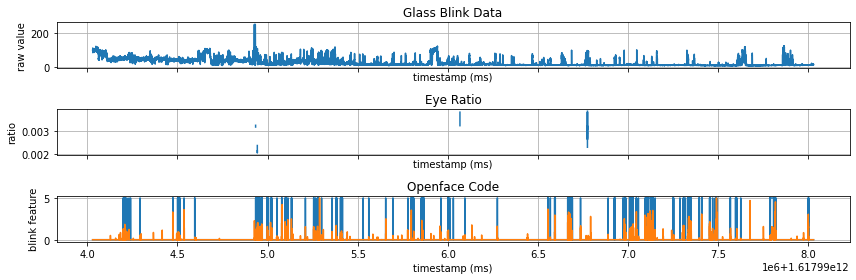

In [23]:
for sess_num in range(len(blink_sess)):
    print('BLINK SESSION', sess_num)
    plot_session(blink_sess[sess_num], df_vid, plot_type='blink')

ACCEL SESSION 0


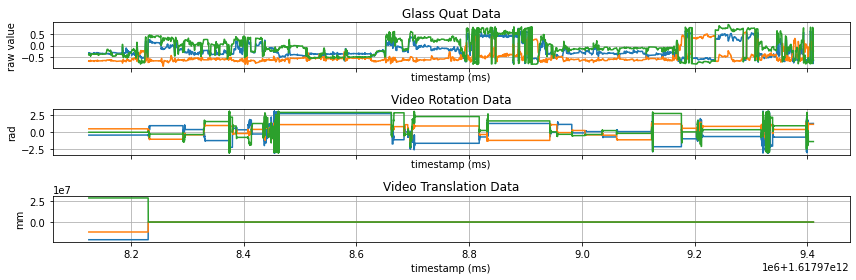

ACCEL SESSION 1


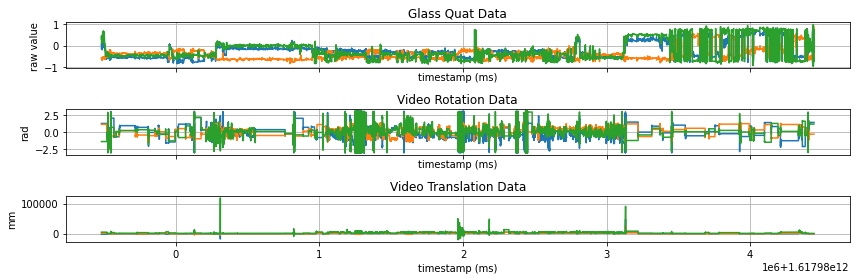

ACCEL SESSION 2


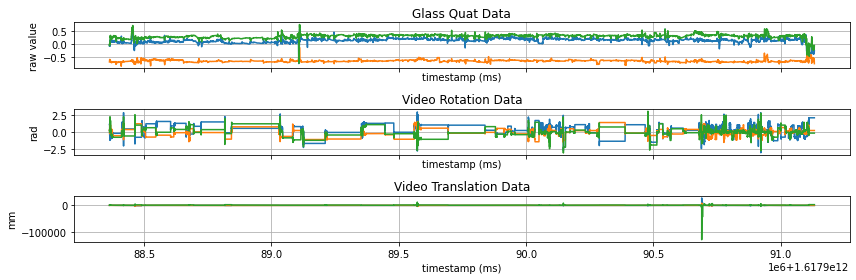

ACCEL SESSION 3


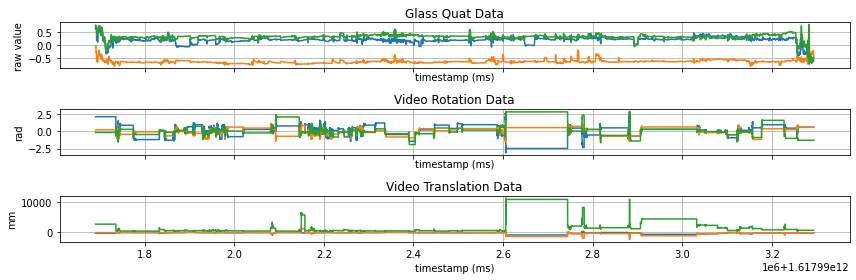

ACCEL SESSION 4


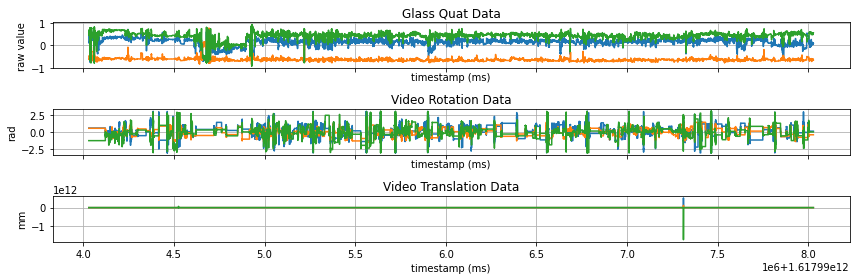

In [24]:
for sess_num in range(len(accel_sess)):
    print('ACCEL SESSION', sess_num)
    plot_session(accel_sess[sess_num], df_vid, plot_type='accel')